<a href="https://colab.research.google.com/github/DataCentricClassificationofSmartCity/XAI-based-Software-Vulnerbility-Dection/blob/main/An_XAI_based_framework_to_assess_software_vulnerability_contribution_factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Overview


This notebook is to explaine the syntatic constructs feature importance from a GNN based model [GraphCodeVec](https://drive.google.com/drive/folders/1BPyl2WPW2G4uHcqkqulGsWMc4IxV3d9o). This model learns the graph-based embeddings for code tokens from both code token information (semantic) and AST path information (contain the syntatic). Then given these code token embeding, the

The process includes:
1. Data Proprocessing.
2. Convert data into Graph Context
   - Convert code into AST (srcML tool) in xml format
   - Convert AST.xml into graph context
3. Training Embedding by GraphCodeVec (GCN-based)
4. Classification by textCNN (can be replaced by Random Forest, Transformer as well)
5. XAI to retrive syntatic construct feature importance order.
   - Masking AST path that with the inflection nodes of a syntatic construct.
   - Retraining embedding (step3) and get classification results (step4).
   - Use masked results and unmasked results (prediction logit in this case) as XAI input.
6. Calculate CWE Similarity

In [16]:
import joblib
import os
import numpy as np
import pandas as pd

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1 Data Pre-processing

To achieve better multi-classification performance, we combine the CWE label less than 10% counts into one CWE.

In [19]:
#@title load_label_multi_cwe { run: "auto" }
root_path = "your path to dataset" #https://github.com/DataCentricClassificationofSmartCity/XAI-based-Software-Vulnerbility-Dection/tree/main/dataset
dataset_name = "juliet"
dataset_path = f'{root_path}/'

import pandas as pd
import numpy as np
import os

train_data_csv = pd.read_csv(
    os.path.join(dataset_path, f'{dataset_name}_train_full.csv'))


test_data_csv = pd.read_csv(
    os.path.join(dataset_path, f'{dataset_name}_test_full.csv'))

def clear_data(x):
    # return [d.replace('\n', '') for d in x]
    return x

x_train = train_data_csv['code']
x_test = test_data_csv['code']
y_train = list(train_data_csv['CWE'])
y_test = list(test_data_csv['CWE'])

y_train = np.array(y_train)
y_test = np.array(y_test)
test_data_csv.head()

,data,code,label,CWE
0,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,package testcases._Relative_Path_Traversal;\r\...,CWE,CWE23
1,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,package testcases._Absolute_Path_Traversal;\r\...,CWE,CWE36
2,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,package testcases._Absolute_Path_Traversal;\r\...,CWE,CWE36
3,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,package testcases._Absolute_Path_Traversal;\r\...,CWE,CWE36
4,/* TEMPLATE GENERATED TESTCASE FILE\nFilename:...,package testcases._Absolute_Path_Traversal;\r\...,CWE,CWE36


### 2 Convert data into Graph Context





- Convert code into AST (srcML tool) in xml format

An example of AST.xml can be found at: [juliet.xml](https://drive.google.com/drive/folders/1HghzpHcLoKsQFbj2fYkkxHapa9E2Oe55?usp=sharing)

The code to covert the AST.xml as [srcML Convert XML tool](https://github.com/youyinnn/code_vulneravility_tools/blob/main/srcml.ipynb)

- Convert AST.xml into graph context

An example of graph context format (juliet) can be found:[juliet_graph_context](https://drive.google.com/drive/folders/1ZKLsX3SZi6frFcNQ79Sv1UP-QnZ5rw2U?usp=sharing)

The code to covert AST.xml into graph context as [XML Convert Graph Context tool](https://github.com/youyinnn/code_vulneravility_tools/blob/main/data_process.ipynb)



The graph context includes:


1.   id2freq.txt contains frequency of words in the corpus.
2.   de2id.txt mapping of ast_path_label to their unique identifiers.
3.   voc2id.txt mapping of words to to their unique identifiers.
4.   data.txt contains the entire code token and their AST path as a fomart:<num_tokens> <num_ast_paths> tok1 tok2 tok3 ... tokn ast_e1 ast_e2 .... ast_em
Here, num_tokens is the number of tokens and num_ast_paths denotes the number of AST path in the code.
tok_1, tok_2 ... is the list of tokens in the code and ast_e1, ast_e2 ...is the list of AST path where each is of form source_token|target_token|ast_path_label.graph context





### 3 Training Embedding by GraphCodeVec (GCN-based)

- input: the [graph_context](https://drive.google.com/drive/folders/1ZKLsX3SZi6frFcNQ79Sv1UP-QnZ5rw2U)
- model & code: [GraphCodeVec](https://drive.google.com/drive/folders/1BPyl2WPW2G4uHcqkqulGsWMc4IxV3d9o)
- output: an embedding for each code tokens. an [example](https://drive.google.com/file/d/1KX7J0nRWjgPAOA8bz2PZClWsdDBmhVF9/view?usp=sharing) can be found. This pkl file could convert to .txt format (similar with [word2vec](https://en.wikipedia.org/wiki/Word2vec)) for easy usage. The code tokens with a 128-dimension vector are provided in the embedding.

An example of embedding output as .txt:

In [ ]:
#@title convert embedding to .txt format { run: "auto" }
filename = 'https://drive.google.com/file/d/1KX7J0nRWjgPAOA8bz2PZClWsdDBmhVF9/view/0.pkl'
if_padding = "True" #@param ["True", "False"]
with open(filename, 'rb') as fo:
   embedding = joblib.load(fo)
if if_padding == "True":
  embedding['padding'] = np.zeros(128,dtype=np.float32)
embedding = {k: list(v) for k, v in embedding.items()}

def save_dict_to_txt(dictionary, file_name):
    count = 0
    with open(file_name, 'w') as f:
        for key, value in dictionary.items():
            count+=1
            f.write(key + ' ')
            f.write(' '.join([str(x) for x in value]) + '\n')
    print(count)
save_dict_to_txt(embedding, 'embedding.txt')

### 4 Classification by textCNN



In [ ]:
#@title Data_Loading

root_path = "your_graph_context_path/"

import pandas as pd
import numpy as np
import os

#map code samples
path =  os.path.join(root_path, 'data_xml_map.txt')
label_idx = []
with open(path, 'r') as f:
    # Read the lines of the file
    lines = f.readlines()
    for line in lines:
    # Split the line into words
      words = line.split(".")
      label_idx.append(int(words[2]))
y_train_map = [y_train[i] for i in label_idx if i <len(y_train)]
y_test_map = [y_test[i-len(y_train)] for i in label_idx[len(y_train_map):]]

#load token_idx
path =  os.path.join(root_path, 'data.txt')
if_padding = "True" #@param ["True", "False"]
padding_len = "128" #@param ["64", "128", "256"]
with open(path, 'r') as f:
    # Read the lines of the file
    lines = f.readlines()
# Initialize an empty list to store the numbers
token = []
count = 0
# Iterate over the lines
for line in lines:
    # Split the line into words
    words = line.split()
    # Convert the first word to a float and append it to the list
    token_n = int(words[0])
    codes = [int(word) for word in words[2:2+token_n]]
    if if_padding == "True":
      padded_codes = np.pad(codes, (0, int(padding_len) - len(codes)), 'constant', constant_values=-1)
      token.append(padded_codes)
    else:
      token.append(codes)
    count+=1
# Convert the list to a NumPy array
token_number = np.array(token)

#load token_dict
path =  os.path.join(root_path, 'voc2id.txt')
token_id = {}
with open(path, 'r') as f:
    # Read the lines of the file
    lines = f.readlines()
for line in lines:
    # Split the line into words
    words = line.split()
    # Convert the first word to a float and append it to the list
    token_id[int(words[1])] = words[0]
if if_padding == "True":
  token_id[-1] = 'padding'


In [ ]:
#@title Generate_classification_training_data { run: "auto" }
def process_data(y_train_map, y_test_map, token_number, token_id, embedding):
    y_train_final = y_train_map
    y_test_final = y_test_map
    x_train_id = token_number[:len(y_train_final)]
    x_test_id = token_number[len(y_train_final):len(y_train_final)+len(y_test_final)]

    def ebd_check(embedding, i):
        if i in embedding.keys():
            return embedding[i]
        else:
            return embedding['padding']

    x_train_token = np.array(list(map(lambda j: np.array(list(map(lambda i: token_id[i], j))), x_train_id)))
    x_test_token = np.array(list(map(lambda j: np.array(list(map(lambda i: token_id[i], j))), x_test_id)))

    x_train_emb = np.array(list(map(lambda j: np.array(list(map(lambda i: ebd_check(embedding,i), j))), x_train_token)))
    x_test_emb = np.array(list(map(lambda j: np.array(list(map(lambda i: ebd_check(embedding,i), j))), x_test_token)))

    x_train_emb = np.reshape(x_train_emb, (x_train_emb.shape[0], -1))
    x_test_emb = np.reshape(x_test_emb, (x_test_emb.shape[0], -1))

    max_sentence_len = 100  # adjust this value based on your data
    padding_value = 0  # adjust this value based on your data

    def pad_or_truncate(tokens):
        if len(tokens) > max_sentence_len:
            return tokens[:max_sentence_len]
        elif len(tokens) < max_sentence_len:
            return np.concatenate((tokens, [padding_value] * (max_sentence_len - len(tokens))))
        else:
            return tokens

    x_train_token = list(map(pad_or_truncate, x_train_token))
    x_test_token = list(map(pad_or_truncate, x_test_token))

    x_train_emb = np.array([ebd_check(embedding,i) for j in x_train_token for i in j])
    x_train_emb = x_train_emb.reshape(len(x_train_token), -1, 128)

    x_test_emb = np.array([ebd_check(embedding,i) for j in x_test_token for i in j])
    x_test_emb = x_test_emb.reshape(len(x_test_token), -1, 128)

    return x_train_token, x_test_token, x_train_emb, x_test_emb, y_train_final, y_test_final

x_train_token, x_test_token, x_train_emb, x_test_emb, y_train_final, y_test_final = process_data(y_train_map, y_test_map, token_number, token_id, embedding)

In [ ]:
#@title Convert data.txt into csv (text,label) { run: "auto" }
text = np.concatenate([x_train_token, x_test_token], axis=0)
label = y_train_final + y_test_final
label = np.array(label)

import pandas as pd
def convert_str(text):
  text_convert = []
  for method in text:
    text_convert.append(' '.join(method))
  return text_convert

def save_csv(text,label,name='dataset.csv'):
  text_convert = convert_str(text)
  data_pd = pd.DataFrame(np.array(text_convert), columns=['text'])
  data_pd['label'] = label
  data_pd.to_csv(name,index=False)

# save_csv(text,label)
save_csv(x_train_token,y_train_final,'d_train.csv')
save_csv(x_test_token,y_test_final,'d_valid.csv')

In [ ]:
#@title Random Forest
from sklearn.ensemble import RandomForestClassifier
x_train_emb_2d = x_train_emb.reshape(x_train_emb.shape[0], -1)
x_test_emb_2d = x_test_emb.reshape(x_test_emb.shape[0], -1)

forest = RandomForestClassifier()
forest = forest.fit(x_train_emb_2d, y_train_final)

from sklearn.metrics import accuracy_score, classification_report,precision_recall_fscore_support
predictions = forest.predict(x_test_emb_2d)

print("Accuracy: ", accuracy_score(y_test_final, predictions))
print(classification_report(y_test_final, predictions))

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test_final, predictions, average='weighted')
print(precision, recall, f1)

0.8275735563871157 0.788135593220339 0.7886873880424602


In [ ]:
!pip install torchtext==0.4.0
!pip install torch==1.4.0

In [ ]:
#@title TextCNN
import torch
import torch.nn as nn
import torch.nn.functional as F

#%% Text CNN model
#  textCNN(vocab, args.out_channel, kernels, args.dropout, args.num_class, args.pretrained, args.fix_embeddings).to(device)


class textCNN(nn.Module):

    def __init__(self, vocab_built, dim_channel, kernel_wins, dropout_rate, num_class, pre_trained, static=False):
        super(textCNN, self).__init__()
        #load pretrained embedding in embedding layer.
        if pre_trained != '':
            emb_dim = vocab_built.vectors.size()[1]
            self.embed = nn.Embedding(len(vocab_built), emb_dim)
            self.embed.weight.data.copy_(vocab_built.vectors)
            if static:
                self.embed.weight.requires_grad = False
        else:
            print("training without pre-trained...in model.py")
            emb_dim = 128
            self.embed = nn.Embedding(len(vocab_built), emb_dim)
            print(self.embed)
        #Convolutional Layers with different window size kernels
        self.convs = nn.ModuleList([nn.Conv2d(1, dim_channel, (w, emb_dim)) for w in kernel_wins])
        #Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        #FC layer
        self.fc = nn.Linear(len(kernel_wins)*dim_channel, num_class)

    def forward(self, x):
        emb_x = self.embed(x)
        emb_x = emb_x.unsqueeze(1)

        con_x = [conv(emb_x) for conv in self.convs]

        pool_x = [F.max_pool1d(x.squeeze(-1), x.size()[2]) for x in con_x]

        fc_x = torch.cat(pool_x, dim=1)

        fc_x = fc_x.squeeze(-1)

        fc_x = self.dropout(fc_x)
        logit = self.fc(fc_x)
        return logit

    def show_ebd(self):
        return self.embed


In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Sep 14 17:29:01 2019

@author: HSU, CHIH-CHAO

"""
import re

import pandas as pd
from numpy.random import RandomState

import torchtext
from torchtext.data import Field
from torchtext.data import TabularDataset
from torchtext.vocab import GloVe
from torchtext.data import Iterator, BucketIterator
import torchtext.datasets
from torchtext.vocab import Vectors

# import spacy

def split_train_valid(path_data, path_train, path_valid, frac=0.7):
    df = pd.read_csv(path_data)
    rng = 1
    tr = df.sample(frac=0.7, random_state=rng)
    tst = df.loc[~df.index.isin(tr.index)]
    print("Spliting original file to train/valid set...")
    tr.to_csv(path_train, index=False)
    tst.to_csv(path_valid, index=False)

def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip()


def preprocess_methods(all_code_str):
    replacements = [(r"\r\n", " "), (r"[\"',]", " "), (r"[^A-Za-z]", ' '), (r"\s+", " ")]
    all_code_str = all_code_str.replace('/*', '').lower()
    for pat, repl in replacements:
        all_code_str = re.sub(pat, repl, all_code_str)
    return all_code_str


def create_tabular_dataset(path_train, path_valid, pretrained_emb_path=''):

    def tokenizer(text):
        text = preprocess_methods(text)
        return [tok.strip() for tok in text.split(' ') if tok.strip()]

    #Creating field for text and label
    TEXT = Field(sequential=True, tokenize=tokenizer, lower=True)
    LABEL = Field(sequential=False)

    print('Preprocessing the text...')
    #clean the text
    TEXT.preprocessing = torchtext.data.Pipeline(preprocess_methods)

    print('Creating tabular datasets...It might take a while to finish!')
    train_datafield = [('text', TEXT),  ('label', LABEL)]
    tabular_train = TabularDataset(path = path_train,
                                 format= 'csv',
                                 skip_header=True,
                                 fields=train_datafield)

    valid_datafield = [('text', TEXT),  ('label',LABEL)]

    tabular_valid = TabularDataset(path = path_valid,
                           format='csv',
                           skip_header=True,
                           fields=valid_datafield)


    print('Building vocaulary...')
    TEXT.build_vocab(tabular_train)
    LABEL.build_vocab(tabular_train)

    print(tabular_valid[0].label)
    if pretrained_emb_path != '':
        print("Loading pre-trained embeddings from {}".format(pretrained_emb_path))
        pretrained_emb = Vectors(pretrained_emb_path)
        TEXT.vocab.set_vectors(pretrained_emb.stoi, pretrained_emb.vectors, pretrained_emb.dim)
    else:
        print("Training without pre-trained embeddings...")

    return tabular_train, tabular_valid, TEXT.vocab

def create_data_iterator(tr_batch_size, val_batch_size,tabular_train,
                         tabular_valid, d):
    #Create the Iterator for datasets (Iterator works like dataloader)

    train_iter = Iterator(
            tabular_train,
            batch_size=tr_batch_size,
            device = d,
            sort_within_batch=False,
            repeat=False)

    valid_iter = Iterator(
            tabular_valid,
            batch_size=val_batch_size,
            device=d,
            sort_within_batch=False,
            repeat=False)

    return train_iter, valid_iter

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import f1_score

def train(m, device, train_itr, optimizer, epoch, max_epoch):
    m.train()
    corrects, train_loss = 0.0,0
    all_targets = []
    all_predictions = []

    for batch in train_itr:
        text, target = batch.text, batch.label
        text = torch.transpose(text,0, 1)
        target.data.sub_(1)
        text, target = text.to(device), target.to(device)
        optimizer.zero_grad()
        logit = m(text)

        loss = F.cross_entropy(logit, target)
        loss.backward()
        optimizer.step()

        train_loss+= loss.item()
        result = torch.max(logit,1)[1]
        corrects += (result.view(target.size()).data == target.data).sum()

        # Keep track of targets and predictions to compute F1 score later
        all_targets.extend(target.view(-1).cpu().data.numpy().tolist())
        all_predictions.extend(result.view(-1).cpu().data.numpy().tolist())

    size = len(train_itr.dataset)
    train_loss /= size
    accuracy = 100.0 * corrects/size

    # Calculate F1 score
    # f1 = f1_score(all_targets, all_predictions, average='weighted')  # Use 'weighted' if you have a multi-class problem
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted', zero_division=1)
    return train_loss, accuracy, precision_weighted, recall_weighted, f1_weighted

def valid(m, device, test_itr):
    m.eval()
    corrects, test_loss = 0.0,0
    all_targets = []
    all_predictions = []

    for batch in test_itr:
        text, target = batch.text, batch.label
        text = torch.transpose(text, 0, 1)
        target.data.sub_(1)
        text, target = text.to(device), target.to(device)

        logit = m(text)
        loss = F.cross_entropy(logit, target)

        test_loss += loss.item()
        result = torch.max(logit,1)[1]
        corrects += (result.view(target.size()).data == target.data).sum()

        # Keep track of targets and predictions to compute F1 score later
        all_targets.extend(target.view(-1).cpu().data.numpy().tolist())
        all_predictions.extend(result.view(-1).cpu().data.numpy().tolist())

    size = len(test_itr.dataset)
    test_loss /= size
    accuracy = 100.0 * corrects/size

    # Calculate F1 score
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted', zero_division=1)
    return test_loss, accuracy, precision_weighted, recall_weighted, f1_weighted


In [ ]:
import argparse
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
print("Pytorch Version:", torch.__version__)
parser = argparse.ArgumentParser(description='TextCNN')
#Training args
parser.add_argument('--data', type=str, default='./IMDB_Dataset.csv',
                    help='file path of training data in CSV format (default: ./train.csv)')

parser.add_argument('--fixembeddings', type=str, default='True',
                    help='language choice for spacy to tokenize the text')

parser.add_argument('--pretrained', type=str, default='',
                help='choice of pretrined word embedding from torchtext')

parser.add_argument('--epochs', type=int, default=10,
                    help='number of epochs to train (default: 10)')

parser.add_argument('--lr', type=float, default=0.001,
                    help='learning rate (default: 0.01)')

parser.add_argument('--momentum', type=float, default=0.9,
                    help='SGD momentum (default: 0.9)')

parser.add_argument('--batch-size', type=int, default=64,
                help='input batch size for training (default: 64)')

parser.add_argument('--val-batch-size', type=int, default=64,
                    help='input batch size for testing (default: 64)')

parser.add_argument('--kernel-height', type=str, default='3,4,5',
                help='how many kernel width for convolution (default: 3, 4, 5)')

parser.add_argument('--out-channel', type=int, default=100,
                help='output channel for convolutionaly layer (default: 100)')

parser.add_argument('--dropout', type=float, default=0.5,
                    help='dropout rate for linear layer (default: 0.5)')

parser.add_argument('--num_class', type=int, default=4,
                    help='number of category to classify (default: 2)')

#if you are using jupyternotebook with argparser
args = parser.parse_known_args()[0]
# args = parser.parse_args()



Pytorch Version: 2.0.1+cu118


In [ ]:
# args.data = '/content/drive/MyDrive/codevgcn/old/juliet/owasp.csv'
# args.data = './drapper_dataset.csv'
args.pretrained = './embedding.txt'
# args.pretrained = ''
args.epochs = 300
args.fixembeddings= True
args.lr = 0.0005
# args.batch-size = 64
# args.val-batch-size =64
args.num_class = 4
dataset_name = 'juliet'
model_save_path = 'your_path_to_save_model/'

# --kernel-height 3,4,5 --out-channel 100 --dropout 0.5 --num-class 104
print(args.pretrained)
if args.fixembeddings == True:
    args.fixembeddings = True
else:
    args.fixembeddings = False
    print('Use without fine-tuning embeddings///')

print(args.fixembeddings)

./embedding.txt
True


In [ ]:

#Use GPU if it is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainset, validset, vocab = create_tabular_dataset('./d_train.csv',
                              './d_valid.csv', args.pretrained)

#%%Show some example to show the dataset
print("Show some examples from train/valid..")
print(trainset[0].text,  trainset[0].label)
print(validset[0].text,  validset[0].label)

train_iter, valid_iter = create_data_iterator(args.batch_size, args.val_batch_size,
                                                      trainset, validset,device)

#%%Create
kernels = [int(x) for x in args.kernel_height.split(',')]
m = textCNN(vocab, args.out_channel, kernels, args.dropout, args.num_class, args.pretrained, args.fixembeddings).to(device)
# print the model summery
print(m)


#optimizer
optimizer = optim.Adam(m.parameters(), lr=args.lr)


Preprocessing the text...
Creating tabular datasets...It might take a while to finish!
Building vocaulary...
CWE
Loading pre-trained embeddings from ./embedding.txt


 99%|█████████▉| 183/184 [00:00<00:00, 2784.51it/s]

Show some examples from train/valid..
['public', 'void', 'action', 'string', 'data', 'httpservletrequest', 'request', 'httpservletresponse', 'response', 'throws', 'throwable', 'connection', 'dbconnection', 'io', 'getdbconnection', 'preparedstatement', 'null', 'resultset', 'int', 'id', 'try', 'integer', 'parseint', 'catch', 'numberformatexception', 'nfx', 'preparestatement', 'selectfrominvoiceswhereuid', 'setint', 'executequery', 'writestring', 'badresultrequested', 'n', 'sqlexception', 'exceptsql', 'logger', 'log', 'level', 'warning', 'errorexecutingquery', 'finally', 'if', 'close', 'couldnotcloseresultset', 'couldnotclosepreparedstatement', 'couldnotcloseconnection'] CWE
['public', 'void', 'action', 'string', 'data', 'errorclosingfileinputstream', 'throws', 'throwable', 'io', 'null', 'try', 'catch', 'logger', 'log', 'level', 'warning', 'finally', 'if', 'close', 'system', 'getproperty', 'osname', 'tolowercase', 'indexof', 'win', 'else', 'new', 'writeline', 'root', 'cuploads', 'homeuser

In [ ]:
train_f1 = []
test_f1 = []
train_prec = []
test_recall = []
train_recall = []
test_prec = []
best_train_f1 = 0

for epoch in range(1, args.epochs+1):
    #train loss
    tr_loss, tr_acc, tr_prec, tr_recall, tr_f1 = train(m, device, train_iter, optimizer, epoch, args.epochs)
    print('Train Epoch: {} \t Prec: {} \t Recall: {}% \t F1 Score: {}'.format(epoch, tr_prec, tr_recall, tr_f1))

    ts_loss, ts_acc, ts_prec, ts_recall, ts_f1 = valid(m, device, valid_iter)
    print('Valid Epoch: {} \t Prec: {} \t Recall: {}% \t F1 Score: {}'.format(epoch, ts_prec, ts_recall, ts_f1))

    if tr_f1 > best_train_f1:
        best_train_f1 = tr_f1
        best_test_f1 = ts_f1
        #save paras(snapshot)
        print("model saves at {}% accuracy".format(best_test_f1))
        torch.save(m.state_dict(), f"{model_save_path}TextCNN_{dataset_name}_{str(best_test_f1)}.pt")

    train_prec.append(tr_prec)
    train_recall.append(tr_recall)
    train_f1.append(tr_f1)
    test_prec.append(ts_prec)
    test_recall.append(ts_recall)
    test_f1.append(ts_f1)

print(best_test_f1)

Evaluation

In [ ]:
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, precision_recall_fscore_support

def evaluate_model(model_path, m, device, data_iter):
    m.load_state_dict(torch.load(model_path))
    m.eval()

    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for batch in data_iter:
            text, target = batch.text, batch.label
            text = torch.transpose(text,0, 1)
            target.data.sub_(1)
            text, target = text.to(device), target.to(device)

            logit = m(text)
            result = torch.max(logit,1)[1]

            all_targets.extend(target.view(-1).cpu().data.numpy().tolist())
            all_predictions.extend(result.view(-1).cpu().data.numpy().tolist())

    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted', zero_division=1)
    precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(all_targets, all_predictions, average='micro', zero_division=1)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(all_targets, all_predictions, average='macro', zero_division=1)


    print(f'Precision (weighted): {precision_weighted}')
    print(f'Recall (weighted): {recall_weighted}')
    print(f'F1 Score (weighted): {f1_weighted}')

    print(f'Precision (micro): {precision_micro}')
    print(f'Recall (micro): {recall_micro}')
    print(f'F1 Score (micro): {f1_micro}')

    print(f'Precision (macro): {precision_macro}')
    print(f'Recall (macro): {recall_macro}')
    print(f'F1 Score (macro): {f1_macro}')


In [ ]:
model_path = 'your_path_to_save_model/your_saved_model'
evaluate_model(model_path, m, device, valid_iter)

Precision (weighted): 0.8411622276029056
Recall (weighted): 0.8305084745762712
F1 Score (weighted): 0.8306793329688354
Precision (micro): 0.8305084745762712
Recall (micro): 0.8305084745762712
F1 Score (micro): 0.8305084745762712
Precision (macro): 0.7857142857142857
Recall (macro): 0.8142701525054465
F1 Score (macro): 0.7956149193548387


# 5-1 XAI Method: Mean-Centroid Preddiff

In [ ]:
#@title Mean-Centriod Preddiff
import scipy.cluster.hierarchy as shc
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from collections import Counter
from sklearn import preprocessing as pp
from math import atan2, degrees, radians
import time
import numpy as np

def Mean_Centroid_PredDiff_Main(score_training,cluster_num=2):
  centroid_list=[]
  # time_hc = []
  # time_scatter = []
  start = time.process_time()
  X,centroid,label,_ = GMM(score_training,cluster_num)
  c = calucate_feature_importance(label,centroid)
  end = time.process_time()
  # plot_scatter(X,centroid,c,'juliet')
  angel = get_angle(c)
  time_consuming = end-start
  return(c,centroid,angel,time_consuming)

def sub_sample(points, num):
    ind = np.arange(len(points))
    sub_ind = np.random.choice(ind, num, replace=False)
    sub_points = np.array(points)[sub_ind]  # numpy array

    return sub_points.tolist()

def data_clean(train_data,data_clean_thrd):
  arr_num = []
  for arr in train_data:
    if arr[0]>data_clean_thrd:
      arr_num.append(arr)
  train_data_clean = np.array(arr_num)
  return train_data_clean

def GMM(train_data,n_components):
  gm = GaussianMixture(n_components=n_components, random_state=0).fit(train_data)
  centroid = gm.means_
  label = gm.predict(train_data)
  prob = gm.predict_proba(train_data)
  return train_data,centroid,label,prob

def calucate_feature_importance(label,centroid):
  d = Counter(label)
  x_sum=y_sum=count=0
  for point in centroid:
    # x.append(point[0]*d[count])
    # y.append(point[1]*d[count])
    x_sum += point[0]*d[count]
    y_sum += point[1]*d[count]
    count +=1
    c = np.array([x_sum/len(label),y_sum/len(label)])
  return c

def get_angle(point_1, point_2=[0,0]): #These can also be four parameters instead of two arrays
    angle = atan2(abs(point_1[0]) - point_2[1], abs(point_1[1]) - point_2[0])
    # #Optional
    # angle = degrees(angle)
    # # OR
    # angle = radians(angle)
    return angle

def get_score_training(pred_dict,data_name = 'juliet'):
  pred_diff_dict = {}
  for keys, values in pred_dict.items():
    if keys == data_name:
      continue
    pred_diff_dict[keys] = np.column_stack((np.array(pred_dict[data_name]) - np.array(values), np.array(pred_dict[data_name])))
    # pred_diff_dict[keys] = np.array(pred_dict['juliet']) - np.array(values)
  return pred_diff_dict

# 5-2 Perfrom XAI Method

1. Mask syntatic contructs and retraining the embeddings.
Here are the [code](https://github.com/youyinnn/code_vulneravility_tools/blob/main/data_process2.ipynb) to mask contructs, and derive the masked graph_context.

    An example of the [generated graph](https://drive.google.com/drive/folders/1OnLNIgXsx9d7DYmyrYRdbSfYkDlmzOHO?usp=sharing) context with masked construct "decl".

2. Re_training the masked graph context by GraphCodeVec (Step3). Renew the embedding with masked constructs. save your un_masked embedding in *data_path*, and your masked embedding in *embedding_path*
3. Load Pre-trained Classification model from Step4.

4. Get Prediction difference (with un-masked embedding and masked embedding)

5. Calculate feature (sytatic constructs) contribution value by XAI method (Step5-1)

In [ ]:
#@title Load_pretrain_model
import torch
import torch.nn as nn
import torch.nn.functional as F

#%% Text CNN model
#  textCNN(vocab, args.out_channel, kernels, args.dropout, args.num_class, args.pretrained, args.fix_embeddings).to(device)


class textCNN(nn.Module):

    def __init__(self, vocab_built, dim_channel, kernel_wins, dropout_rate, num_class, pre_trained, static=False):
        super(textCNN, self).__init__()
        #load pretrained embedding in embedding layer.
        if pre_trained != '':
            emb_dim = vocab_built.vectors.size()[1]
            self.embed = nn.Embedding(len(vocab_built), emb_dim)
            self.embed.weight.data.copy_(vocab_built.vectors)
            if static:
                self.embed.weight.requires_grad = False
        else:
            print("training without pre-trained...in model.py")
            emb_dim = 128
            self.embed = nn.Embedding(len(vocab_built), emb_dim)
        #Convolutional Layers with different window size kernels
        self.convs = nn.ModuleList([nn.Conv2d(1, dim_channel, (w, emb_dim)) for w in kernel_wins])
        #Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        #FC layer
        self.fc = nn.Linear(len(kernel_wins)*dim_channel, num_class)

    def forward(self, x):
        emb_x = self.embed(x)
        emb_x = emb_x.unsqueeze(1)

        con_x = [conv(emb_x) for conv in self.convs]

        pool_x = [F.max_pool1d(x.squeeze(-1), x.size()[2]) for x in con_x]

        fc_x = torch.cat(pool_x, dim=1)

        fc_x = fc_x.squeeze(-1)

        fc_x = self.dropout(fc_x)
        logit = self.fc(fc_x)
        return logit

    def show_ebd(self):
        return self.embed

# -*- coding: utf-8 -*-
"""
Created on Sat Sep 14 17:29:01 2019

@author: HSU, CHIH-CHAO

"""
import re

import pandas as pd
from numpy.random import RandomState

import torchtext
from torchtext.data import Field
from torchtext.data import TabularDataset
from torchtext.vocab import GloVe
from torchtext.data import Iterator, BucketIterator
import torchtext.datasets
from torchtext.vocab import Vectors

# import spacy

def preprocess_methods(all_code_str):
    replacements = [(r"\r\n", " "), (r"[\"',]", " "), (r"[^A-Za-z]", ' '), (r"\s+", " ")]
    all_code_str = all_code_str.replace('/*', '').lower()
    for pat, repl in replacements:
        all_code_str = re.sub(pat, repl, all_code_str)
    return all_code_str


def create_tabular_dataset(path_train, path_valid, pretrained_emb_path=''):
    def tokenizer(text):
        text = preprocess_methods(text)
        return [tok.strip() for tok in text.split(' ') if tok.strip()]

    #Creating field for text and label
    TEXT = Field(sequential=True, tokenize=tokenizer, lower=True)
    LABEL = Field(sequential=False)
    IDX = Field(sequential=False)


    print('Preprocessing the text...')
    #clean the text
    TEXT.preprocessing = torchtext.data.Pipeline(preprocess_methods)

    print('Creating tabular datasets...It might take a while to finish!')
    train_datafield = [('text', TEXT),  ('label', LABEL), ('index', IDX)]
    tabular_train = TabularDataset(path = path_train,
                                 format= 'csv',
                                 skip_header=True,
                                 fields=train_datafield)

    valid_datafield = [('text', TEXT),  ('label', LABEL), ('index', IDX)]

    tabular_valid = TabularDataset(path = path_valid,
                           format='csv',
                           skip_header=True,
                           fields=valid_datafield)


    print('Building vocaulary...')
    TEXT.build_vocab(tabular_train)
    LABEL.build_vocab(tabular_train)
    IDX.build_vocab(tabular_valid)

    print(tabular_valid[0].label)
    if pretrained_emb_path != '':
        print("Loading pre-trained embeddings from {}".format(pretrained_emb_path))
        pretrained_emb = Vectors(pretrained_emb_path)
        TEXT.vocab.set_vectors(pretrained_emb.stoi, pretrained_emb.vectors, pretrained_emb.dim)
    else:
        print("Training without pre-trained embeddings...")

    return tabular_train, tabular_valid, TEXT.vocab

def create_data_iterator(tr_batch_size, val_batch_size,tabular_train,
                         tabular_valid, d):
    #Create the Iterator for datasets (Iterator works like dataloader)

    train_iter = Iterator(
            tabular_train,
            batch_size=tr_batch_size,
            device = d,
            sort_within_batch=False,
            repeat=False)

    valid_iter = Iterator(
            tabular_valid,
            batch_size=val_batch_size,
            device=d,
            sort_within_batch=False,
            repeat=False)

    return train_iter, valid_iter

import torch
import torch.nn.functional as F

#%% Training the Model
def train(m, device, train_itr, optimizer, epoch, max_epoch):
    m.train()
    corrects, train_loss = 0.0,0
    for batch in train_itr:
        text, target = batch.text, batch.label
        text = torch.transpose(text,0, 1)
        target.data.sub_(1)
        text, target = text.to(device), target.to(device)
        optimizer.zero_grad()
        logit = m(text)

        loss = F.cross_entropy(logit, target)
        loss.backward()
        optimizer.step()

        train_loss+= loss.item()
        result = torch.max(logit,1)[1]
        corrects += (result.view(target.size()).data == target.data).sum()

    size = len(train_itr.dataset)
    train_loss /= size
    accuracy = 100.0 * corrects/size

    return train_loss, accuracy

def valid(m, device, test_itr):
    m.eval()
    corrects, test_loss = 0.0,0
    for batch in test_itr:
        text, target = batch.text, batch.label
        text = torch.transpose(text, 0, 1)
        target.data.sub_(1)
        text, target = text.to(device), target.to(device)

        logit = m(text)
        loss = F.cross_entropy(logit, target)


        test_loss += loss.item()
        result = torch.max(logit,1)[1]
        corrects += (result.view(target.size()).data == target.data).sum()

    size = len(test_itr.dataset)
    test_loss /= size
    accuracy = 100.0 * corrects/size

    return test_loss, accuracy

def pred(m, device, test_itr):
    m.eval()
    logit_sum = []
    target_sum = []
    idx_sum = []
    for batch in test_itr:
        text, target, idx = batch.text, batch.label, batch.index
        print(idx)
        text = torch.transpose(text, 0, 1)
        target.data.sub_(1)
        text, target = text.to(device), target.to(device)
        logit = m(text)
        logit_sum.append(logit)
        target_sum.append(target)
        idx_sum.append(idx)
    return logit.detach().numpy(), target.detach().numpy(), idx.detach().numpy()

# -*- coding: utf-8 -*-
"""main.ipynb

@author: HSU, CHIH-CHAO
"""

import argparse

import torch
import torch.optim as optim

# import dataset
# import model
# import training

import matplotlib.pyplot as plt
#%%

# def main():

print("Pytorch Version:", torch.__version__)
parser = argparse.ArgumentParser(description='TextCNN')
#Training args
parser.add_argument('--data', type=str, default='./IMDB_Dataset.csv',
                    help='file path of training data in CSV format (default: ./train.csv)')

parser.add_argument('--fixembeddings', type=str, default='True',
                    help='language choice for spacy to tokenize the text')

parser.add_argument('--pretrained', type=str, default='',
                help='choice of pretrined word embedding from torchtext')

parser.add_argument('--epochs', type=int, default=10,
                    help='number of epochs to train (default: 10)')

parser.add_argument('--lr', type=float, default=0.001,
                    help='learning rate (default: 0.01)')

parser.add_argument('--momentum', type=float, default=0.9,
                    help='SGD momentum (default: 0.9)')

parser.add_argument('--batch-size', type=int, default=64,
                help='input batch size for training (default: 64)')

parser.add_argument('--valbatchsize', type=int, default=64,
                    help='input batch size for testing (default: 64)')

parser.add_argument('--kernel-height', type=str, default='3,4,5',
                help='how many kernel width for convolution (default: 3, 4, 5)')

parser.add_argument('--out-channel', type=int, default=100,
                help='output channel for convolutionaly layer (default: 100)')

parser.add_argument('--dropout', type=float, default=0.5,
                    help='dropout rate for linear layer (default: 0.5)')

parser.add_argument('--num-class', type=int, default=4,
                    help='number of category to classify (default: 2)')

#if you are using jupyternotebook with argparser
args = parser.parse_known_args()[0]
# args = parser.parse_args()


Pytorch Version: 1.4.0


In [ ]:
#@title Get Prediction difference
import pandas as pd

data_path = 'your_path_to_saved_embedding_and_data'

def get_logit_label_from_model(embedding_path = f"{data_path}embedding.txt"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    args.fixembeddings = True
    args.pretrained = embedding_path
    print(args.pretrained)
    args.epochs = 1
    args.valbatchsize = 128
    df_train = pd.read_csv(f"{data_path}d_train.csv")
    df_val = pd.read_csv(f"{data_path}d_valid.csv")
    df_train['index'] =range(1,len(df_train)+1)
    df_val['index'] =range(1,len(df_val)+1)
    df_train.to_csv('df_train.csv',index=False)
    df_val.to_csv('df_val.csv',index=False)
    trainset, validset, vocab = create_tabular_dataset('./df_train.csv',
                                  './df_val.csv', embedding_path)
    print("Show some examples from train/valid..")
    print(validset[0].text,  validset[0].label)
    train_iter, valid_iter = create_data_iterator(args.batch_size, args.valbatchsize,
                                                          trainset, validset,device)
    kernels = [int(x) for x in args.kernel_height.split(',')]
    m = textCNN(vocab, args.out_channel, kernels, args.dropout, args.num_class, embedding_path, args.fixembeddings).to(device)
    print(m)
    optimizer = optim.Adam(m.parameters(), lr=args.lr)
    m.load_state_dict(torch.load(f"{data_path}TextCNN_juliet_tensor(83.0508).pt"))
    m.embed = nn.Embedding(len(vocab), 128)
    m.embed.weight.data.copy_(vocab.vectors)
    # m = textCNN(vocab, args.out_channel, kernels, args.dropout, args.num_class, embedding_path, args.fixembeddings).to(device)
    # print(m)
    ts_loss, ts_acc = valid(m, device, valid_iter)
    print('Valid Epoch: {} \t Loss: {} \t Accuracy: {}%'.format(1, ts_loss, ts_acc))
    logit, target, idx= pred(m, device, valid_iter)
    # print("target",logit, "logit", target, "idx",idx)
    logit_label = [x[target[i]] for i, x in enumerate(logit)]
    sort_logit_label = [x for _, x in sorted(zip(idx, logit_label), key=lambda pair: pair[0])]
    return vocab, sort_logit_label

vocab_1, logit = get_logit_label_from_model()

embedding_path = 'your_path_to_save_masked_embeddings'

def convert_embedding(filename):
    if_padding = "False"
    with open(filename, 'rb') as fo:
      embedding = joblib.load(fo)
    if if_padding == "True":
      embedding['padding'] = np.zeros(128,dtype=np.float32)
    embedding = {k: list(v) for k, v in embedding.items()}
    return embedding

def save_dict_to_txt(dictionary, file_name):
    count = 0
    with open(file_name, 'w') as f:
        for key, value in dictionary.items():
            count+=1
            f.write(key + ' ')
            f.write(' '.join([str(x) for x in value]) + '\n')
    print(count)

# save_dict_to_txt(embedding, 'embedding.txt')

def pred_diff_pipeline(embedding_path):
    # create an empty list to store the file names
    file_names = []
    pred_dict = {}

    # iterate over all files and folders in the specified folder
    for item in os.listdir(embedding_path):
        # construct the full path to the item
        item_path = os.path.join(embedding_path, item)
        if os.path.isdir(item_path):
          continue
        else:
        # check if the item is a file (not a folder)
          feature_name = item.split("_")[0]+"_"+item.split("_")[1]+"_"+item.split("_")[2]
        # if os.path.isfile(item_path):
        #     # append the file name (without the path) to the list
        #     # feature_name = item.split("_")[0]+"_"+item.split("_")[1]+"_"+item.split("_")[2]
        #     print(item)
        #     embedding_path = f"embedding_path{item}"
    # print the list of file names
        feature_embedding = f"{embedding_path}{item}"
        embedding = convert_embedding(feature_embedding)
        save_dict_to_txt(embedding, f"embedding{feature_name}.txt")
        print(f"./embedding{feature_name}.txt")
        _, sort_logit_label = get_logit_label_from_model(f"./embedding{feature_name}.txt")
        pred_dict[feature_name] = sort_logit_label
        file_names.append(f"{embedding_path}{item}")
    return pred_dict
pred_dict = pred_diff_pipeline(embedding_path)
pred_dict['juliet'] = logit

In [ ]:
import pickle
# you can save the pred_dict as a pickle, here is an example: https://drive.google.com/file/d/1-G0V-vWA_uiQlYMtLtTnGoAgMqLvU_IM/view?usp=sharing
with open('your_path_to_pred/pred_juliet.pkl', 'rb') as f:
    pred_dict = pickle.load(f)

In [ ]:
# @title map meta constructs
feature_meta = {'name':'name', 'expr':'statement subelements', 'type':'statement subelements',
 'decl': 'declarations definitions, and initializations', 'literal':'name',
 'call':'expressions',
 'new': 'declarations definitions, and initializations',
 'function':'declarations definitions, and initializations',
 'block_content':'statement subelements',
 'throws':'exceptions',
 'operator':'operator',
 'specifier':'specifier',
 'if':'statement subelements',
 'case':'statement',
 'condition':'statement subelements',
 'annotation':'classes interfaces annotations and enums',
 'argument':'argument',
 'break':'statement',
 'expr_stmt':'statement',
 'init':'declarations definitions, and initializations',
 'block':'statement',
 'throw':'exceptions',
 'if_stmt':'exceptions',
 'catch':'exceptions',
 'return':'statement',
 'decl_stmt':'declarations definitions, and initializations',
 'argument_list':'argument',
 'for':'statement',
 'default':'statement',
 'try':'exceptions',
 'parameter_list':'parameter',
 'parameter':'parameter',
 'control':'statement subelements',
 'switch':'statement',
 'index':'name',
 'else':'statement subelements',
 'while':'statement',
 'incr':'statement subelements',
 'finally':'exceptions',
 'range': 'name',
 'continue':'statement',
 'sizeof':'argument',
 'goto':'statement',
 'juliet':'juliet',
 'owasp':'owasp',
 'drapper':'drapper',
 '30':'name'}
 feature_index = {'name':0, 'expr':1, 'type':2,
 'decl': 3, 'literal':4,
 'call':5,
 'new': 6,
 'function':7,
 'block_content':8,
 'throws':9,
 'operator':10,
 'specifier':11,
 'if':12,
 'case':13,
 'condition':14,
 'annotation':15,
 'argument':16,
 'break':17,
 'expr_stmt':18,
 'init':19,
 'block':20,
 'throw':21,
 'if_stmt':22,
 'catch':23,
 'return':24,
 'decl_stmt':25,
 'argument_list':26,
 'for':27,
 'default':28,
 'try':29,
 'parameter_list':30,
 'parameter':31,
 'control':32,
 'switch':33,
 'index':34,
 'else':35,
 'while':36,
 'incr':37,
 'finally':38,
 'range': 39,
 'continue':40,
 'sizeof':41,
 'goto':42,
 'juliet':43,
 'owasp':44,
 'drapper':45,
 '30':46}

RvsD = {}
for k,v in feature_meta.items():
    RvsD.setdefault(v, []).append(k)
RvsD

In [ ]:
#@title Calculate feature (sytatic constructs) contribution value by XAI method
def clean_dict(pred_dict):
  new_dict={}
  for key, value in pred_dict.items():
      new_key = key.replace("juliet_", "").replace("_out", "").replace("owasp_", "").replace("_30", "").replace("draper_","")
      new_dict[new_key] = value
  return new_dict

def combine_meta(input_dict,map_dict):
    output_dict = {}
    for key, value in input_dict.items():
        mapped_key = map_dict[key]
        if mapped_key == 30:
          pass
        if mapped_key in output_dict:
            output_dict[mapped_key] = np.concatenate((output_dict[mapped_key], value), axis=0)
        else:
            output_dict[mapped_key] = value
    return output_dict

def Mean_Centroid_Pipine(pred_dict, data_name = 'juliet', combine=''):
    pred_diff_dict = clean_dict(pred_dict)
    pred_diff_dict = get_score_training(pred_diff_dict,data_name)
    combine_dict = pred_diff_dict
    if combine == 'meta':
       combine_dict = combine_meta(pred_diff_dict, feature_meta)
    XAI_dict = {}
    XAI_range = {}
    for keys, values in combine_dict.items():
        _,_,angle,time = Mean_Centroid_PredDiff_Main(values,cluster_num=2)
        XAI_dict[keys]=angle
        XAI_range[keys] = [get_angle(point) for point in values]
    return XAI_dict,pred_diff_dict,XAI_range

XAI_dict_meta,pred_diff_dict_meta,XAI_range_meta = Mean_Centroid_Pipine(pred_dict, data_name = 'juliet',combine='meta')
XAI_dict,pred_diff_dict,XAI_range = Mean_Centroid_Pipine(pred_dict, data_name = 'juliet')

In [ ]:
def get_pred_diff_pd(pred_diff_dict, FI_dict):
    pred_dict = {}
    for keys, values in pred_diff_dict.items():
      pred_dict[keys]=values
    print(pred_dict.keys())
    df_list = []
    for key, values in pred_dict.items():
        max_len = max(len(values) for values in pred_dict.values())
        values = np.pad(values, (0, max_len-len(values)), 'constant', constant_values=np.nan)
        df = pd.DataFrame({key: values})
        df_list.append(df)
    df = pd.concat(df_list, axis=1)
    pred_diff_df = pd.DataFrame.from_dict(df)
    df_feature_importance = pd.DataFrame.from_dict(FI_dict, orient='index',columns=['feature importance']).sort_values('feature importance', ascending=False)
    return pred_diff_df, df_feature_importance

In [ ]:
juliet_pd, juliet_FI = get_pred_diff_pd(XAI_range, XAI_dict)
juliet_pd.head()
juliet_pd_meta, juliet_FI_meta = get_pred_diff_pd(XAI_range_meta, XAI_dict_meta)
juliet_pd_meta.head()

dict_keys(['expr_stmt', 'new', 'block', 'parameter', 'name', 'parameter_list', 'else', 'argument', 'call', 'decl_stmt', 'decl', 'finally', 'argument_list', 'try', 'block_content', 'expr', 'specifier', 'throws', 'incr', 'for', 'catch', 'literal', 'return', 'index', 'control', 'if', 'type', 'operator', 'init', 'if_stmt'])
dict_keys(['statement', 'declarations definitions, and initializations', 'parameter', 'name', 'statement subelements', 'argument', 'expressions', 'exceptions', 'specifier', 'operator'])


,statement,"declarations definitions, and initializations",parameter,name,statement subelements,argument,expressions,exceptions,specifier,operator
0,0.591718,0.599011,0.599894,0.617171,0.594484,0.611937,0.600802,0.588944,0.599011,0.597490
1,0.657659,0.676349,0.667589,0.692251,0.662114,0.679874,0.670911,0.658142,0.676349,0.667566
2,0.131914,0.142610,0.161800,0.052837,0.134993,0.070479,0.100160,0.168608,0.142610,0.130930
3,0.187609,0.177988,0.176770,0.201422,0.179798,0.198290,0.200019,0.168989,0.177988,0.177094
4,0.314374,0.320582,0.307181,0.273531,0.293504,0.250593,0.269217,0.330776,0.320582,0.298004


Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


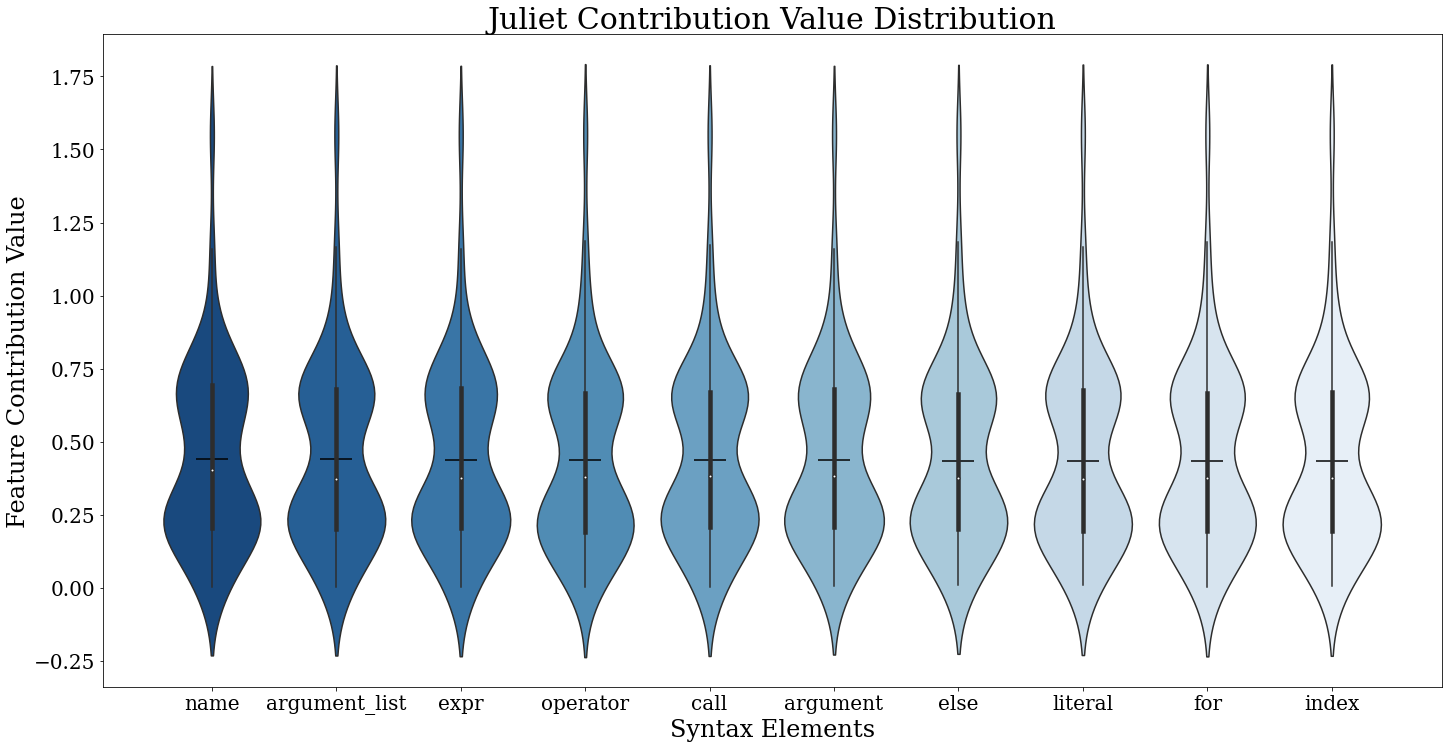

In [ ]:
mpl.rcParams['figure.figsize'] = (24, 12)
df_feature_long = pd.melt(juliet_pd,var_name='Syntax Elements', value_name='Contribution Value')
# sns.stripplot(x="feature name", y="pred_diff", data=df_feature_long, order=juliet_FI.index)
fig, ax = plt.subplots()
sns.violinplot(x="Syntax Elements", y="Contribution Value", data=df_feature_long, order=juliet_FI.index[:10], palette=sns.color_palette("Blues_r", 10),ax=ax)
points = juliet_FI['feature importance'].to_numpy()[:10]
ax = sns.scatterplot(points, ax=ax, color='blue', markers='o', zorder=3)
ax.set_yscale('linear')
ax.set_xlabel("Syntax Elements", fontsize=24)
ax.set_ylabel("Feature Contribution Value", fontsize=24)
plt.scatter(x=range(len(points)),y=points,c="black",marker = '_',s=1000)
# plt.ylim([-0.1, 1])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("Juliet Contribution Value Distribution",fontsize=30)
plt.show()


# 6 Calculate CWE Similarity

After derive the syntatic construct feature contribution value for per code sample.

1. Aggregate CWE-level syntatic construct feature contribution value: average contribution value for these code samples that own the same CWE label.
2. Descenting the syntatic construct contribution value to derive an contruct feature importance order. An example of our pervious [CWE-level contruct feature importance order](https://docs.google.com/spreadsheets/d/1lPNYjThCWT5wwfIPjwMApxFDlNRHU2cfZ389gWqEKUI/edit?usp=sharing).

3. Calcluate [Kendall_tau_distance](https://en.wikipedia.org/wiki/Kendall_tau_distance) between CWE pair ranking order.

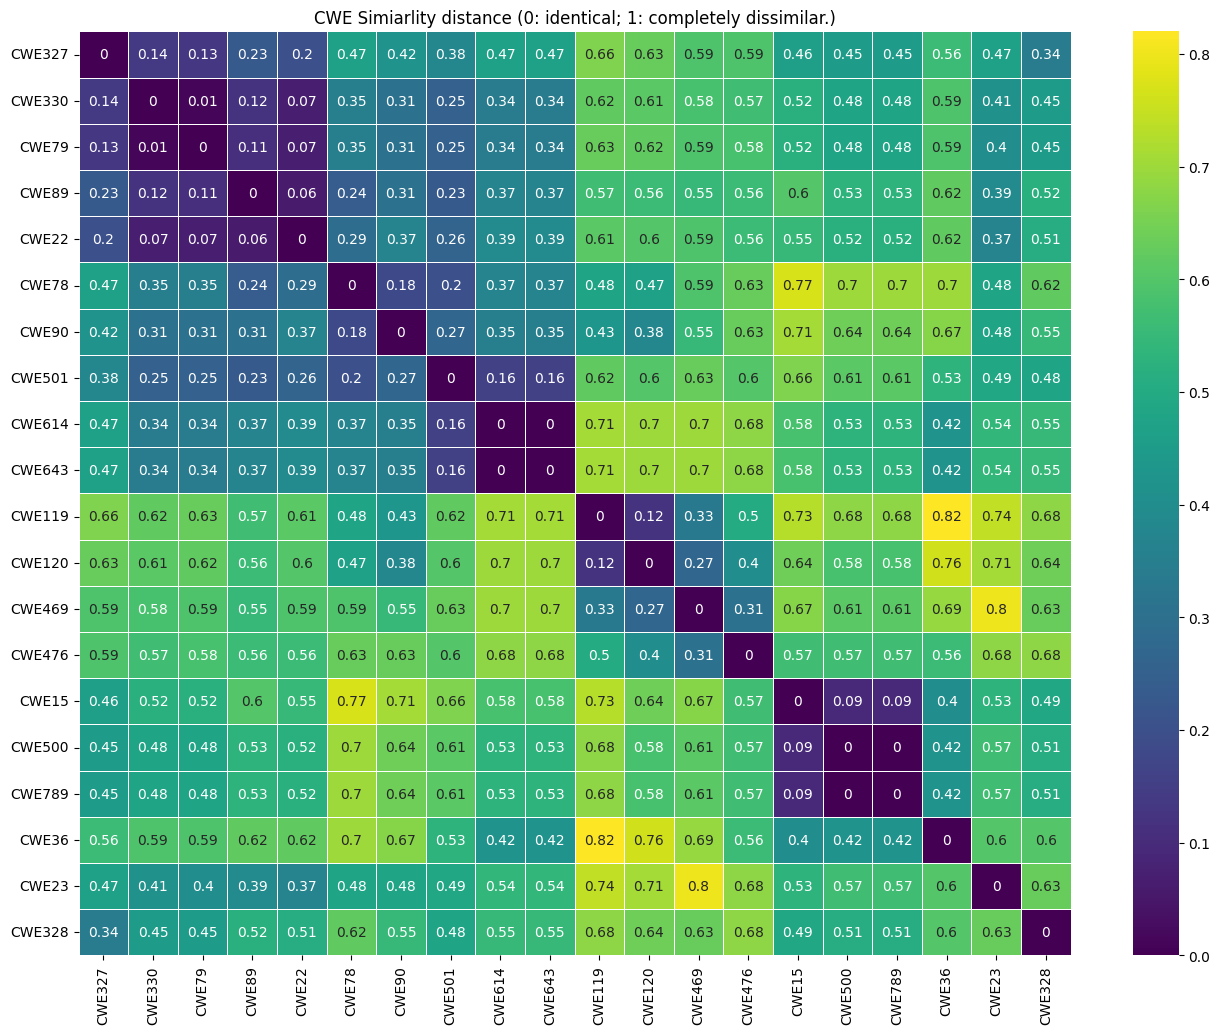

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list

cwe_level_order = pd.read_csv("from_your_CWE-level contruct feature importance order")
# Your CWE contruct feature importance order
data = cwe_level_order.set_index('CWE')['order'].to_dict()
del data['NoCWE']
del data['CWE']

# Find the unique set of features
unique_features = set()
for features in data.values():
    unique_features.update(features)
unique_features = sorted(list(unique_features))

# Convert feature orders to fixed-length vectors
vectors = {}
for cwe, features in data.items():
    vec = [features.index(feat) if feat in features else len(unique_features) for feat in unique_features]
    vectors[cwe] = vec

# Calculate the Kendall Tau distance between each CWE pair
distances = {}
for cwe1, vec1 in vectors.items():
    for cwe2, vec2 in vectors.items():
        tau, _ = kendalltau(vec1, vec2)
        distances.setdefault(cwe1, {})[cwe2] = 1 - tau  # Convert similarity to distance

# Create a DataFrame from the distances dictionary
df = pd.DataFrame(distances)

dist_matrix = pdist(df, metric="euclidean")
link = linkage(dist_matrix, method="ward")
order = leaves_list(link)

# Reorder the DataFrame based on the clustering result
ordered_df = df.iloc[order, :].T.iloc[order, :]
ordered_df = ordered_df.where(df >= 1e-10, 0)
ordered_df = ordered_df.round(2)
# Create a heatmap using the reordered Kendall Tau similarity matrix
plt.figure(figsize=(16, 12))
sns.heatmap(ordered_df, annot=True, cmap="viridis", linewidths=.5)
plt.title("CWE Simiarlity distance (0: identical; 1: completely dissimilar.)")
plt.show()
